In [1]:
# text classification with IMDB data
# one hot encoding method

class Dictionary(object):
    def __init__(self):
        self.word2idx = []
        self.idx2word = []
        self.length = 0;

    def add_word(self, word):
        if word not in self.idx2word:
            self.idx2word.append(word)
            self.word2idx[word] = self.length + 1
            self.length += 1

        return self.word2idx[word]
    
    def __len__(self):
        return self.length
    
    def onehot_encoded(self, word):
        vec = np.zeros(self.length)
        vec[self.word2idx[word]] = 1
        return vec

dic = Dictionary()

In [2]:
# text 분류에 대해서는 torchtext를 이용
!pip3 install torchtext

In [3]:
# kaggle IMDB dataset uploaded
# image classification 
!pip install kaggle

from google.colab  import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

Saving kaggle.json to kaggle.json
 35% 9.00M/25.7M [00:00<00:01, 14.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 35.2MB/s]


In [4]:
from torchtext import data, datasets
from torchtext.vocab import GloVe, FastText, CharNGram
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchtext.datasets.imdb import IMDB
import sys
import os
import torchtext

In [5]:
# dataset setting
TEXT = torchtext.legacy.data.Field(lower = True, batch_first = True, fix_length = 40)
LABEL = torchtext.legacy.data.Field(sequential = False)

train, test = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL) # IMDB dataset downlaod -> tokenize -> split with train/test data
print('train.fields: ', train.fields)
print(vars(train[0]))

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 14.0MB/s]


train.fields:  {'text': <torchtext.legacy.data.field.Field object at 0x7f768fcbb710>, 'label': <torchtext.legacy.data.field.Field object at 0x7f768fcbb790>}
{'text': ['<br', '/><br', '/>in', 'anticipation', 'of', 'ang', "lee's", 'new', 'movie', '"crouching', 'tiger,', 'hidden', 'dragon,"', 'i', 'saw', 'this', 'at', 'blockbuster', 'and', 'figured', "i'd", 'give', 'it', 'a', 'try.', 'a', 'civil', 'war', 'movie', 'is', 'not', 'the', 'typical', 'movie', 'i', 'watch.', 'luckily', 'though,', 'i', 'had', 'a', 'good', 'feeling', 'about', 'this', 'director.', 'this', 'movie', 'was', 'wonderfully', 'written.', 'the', 'dialogue', 'is', 'in', 'the', 'old', 'southern', 'style,', 'yet', "doesn't", 'sound', 'cornily', 'out', 'of', 'place', 'and', 'outdated.', 'the', 'spectacular', 'acting', 'helped', 'that', 'aspect', 'of', 'the', 'movie.', 'toby', 'maguire', 'was', 'awesome.', 'i', 'thought', 'he', 'was', 'good', '(but', 'nothing', 'special)', 'in', 'pleasantville,', 'but', 'here', 'he', 'shines.', 

In [6]:
# 어휘 구축
TEXT.build_vocab(train, vectors = GloVe(name = '6B', dim = 300), max_size = 10000, min_freq = 10)
LABEL.build_vocab(train)

.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 399707/400000 [00:36<00:00, 10345.14it/s]

In [7]:
print(TEXT.vocab.freqs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
print(TEXT.vocab.vectors)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7724, -0.1800,  0.2072,  ...,  0.6736,  0.2263, -0.2919],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [9]:
train_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size = 32, shuffle = True)

In [10]:
batch = next(iter(train_iter))
print(batch.text.size())

torch.Size([32, 40])


In [11]:
print(len(TEXT.vocab.stoi))

10138


In [12]:
# embedding network model

class EmbNet(nn.Module):
    def __init__(self, emb_size, hidden_size1, hidden_size2 = 400):
        super().__init__()
        self.embedding = nn.Embedding(emb_size, hidden_size1) # 어휘 10000 -> 10 차원으로 줄이고
        self.fc = nn.Linear(hidden_size2, 3) # 10차원 * 최대 문장 길이 40

    def forward(self, x):
        embeds = self.embedding(x).view(x.size(0), -1)
        out = self.fc(embeds)

        return F.log_softmax(out, dim = 1)

# model generate and gpu allocation

model = EmbNet(emb_size = len(TEXT.vocab.stoi), hidden_size1 = 10)
model.cuda()

EmbNet(
  (embedding): Embedding(10138, 10)
  (fc): Linear(in_features=400, out_features=3, bias=True)
)

In [13]:
is_cuda = torch.cuda.is_available()

In [14]:
# optimizer

optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-3)

train_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size=32,shuffle=True)
train_iter.repeat = False
test_iter.repeat = False

# fit function definition

from tqdm import tqdm, tqdm_notebook

def fit(epoch, model, dataloader, phase = 'training', volatile = False):
    if phase == 'training':
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True # 이제는 필요 없다. torch.no_grad()로 대체되었다. 즉 gradient를 주지 않는다는 의미이다. 

    train_loss = 0
    train_acc = 0

    for batch_idx, batch in enumerate(tqdm_notebook(dataloader)):

        text, target = batch.text, batch.label

        if is_cuda:
            text, target = text.cuda(), target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        
        output = model(text)
        loss = F.nll_loss(output, target)

        train_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim = 1, keepdim = True)[1] # output tensor type -> data로 호출 가능
        train_acc += preds.eq(target.data.view_as(preds)).cpu().sum()

        if phase == 'training':
            loss.backward()
            optimizer.step()
        
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = train_acc.item() / len(dataloader.dataset)

    print("epoch: {} and loss: {} and acc : {}".format(epoch, train_loss, train_acc))

    return train_loss, train_acc


train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

%time

for epoch in range(1, 8):
    epoch_loss, epoch_acc = fit(epoch, model, train_iter, phase = "training", volatile = False)
    val_epoch_loss, val_epoch_acc = fit(epoch, model, test_iter, phase = 'validation', volatile = True)

    train_losses.append(epoch_loss)
    valid_losses.append(val_epoch_loss)

    train_accuracy.append(epoch_acc)
    valid_accuracy.append(val_epoch_acc)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.25 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



epoch: 1 and loss: 0.7462401390075684 and acc : 0.51592



epoch: 1 and loss: 0.6975414752960205 and acc : 0.54064


100%|█████████▉| 399707/400000 [00:50<00:00, 10345.14it/s]


epoch: 2 and loss: 0.6848323345184326 and acc : 0.57136



epoch: 2 and loss: 0.6762723326683044 and acc : 0.5844



epoch: 3 and loss: 0.6420153379440308 and acc : 0.63244



epoch: 3 and loss: 0.641642153263092 and acc : 0.63372



epoch: 4 and loss: 0.5891507863998413 and acc : 0.68528



epoch: 4 and loss: 0.6138432621955872 and acc : 0.6644



epoch: 5 and loss: 0.5437021851539612 and acc : 0.72008



epoch: 5 and loss: 0.601245641708374 and acc : 0.67912



epoch: 6 and loss: 0.5058269500732422 and acc : 0.74912



epoch: 6 and loss: 0.59516441822052 and acc : 0.69112



epoch: 7 and loss: 0.4743598997592926 and acc : 0.77124



epoch: 7 and loss: 0.5912959575653076 and acc : 0.6962


In [15]:
# using GloVe pretrained model

TEXT = torchtext.legacy.data.Field(lower = True, batch_first = True, fix_length = 40)
LABEL = torchtext.legacy.data.Field(sequential= False)

train, test = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL) # IMDB dataset downlaod -> tokenize -> split with train/test data

TEXT.build_vocab(train,test, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=10)
LABEL.build_vocab(train,)

class EmbNet(nn.Module):
    def __init__(self, emb_size, hidden_size1, hidden_size2 = 400):
        super().__init__()
        self.embedding = nn.Embedding(emb_size, hidden_size1) # 어휘 10000 -> 10 차원으로 줄이고
        self.fc = nn.Linear(hidden_size2, 3) # 10차원 * 최대 문장 길이 40

    def forward(self, x):
        embeds = self.embedding(x).view(x.size(0), -1)
        out = self.fc(embeds)

        return F.log_softmax(out, dim = 1)

# model generate and gpu allocation

model = EmbNet(emb_size = len(TEXT.vocab.stoi), hidden_size1 = 300, hidden_size2 = 300 * 40)
model.cuda()

# pretrained model weight download
model.embedding.weight.data = TEXT.vocab.vectors.cuda()
model.embedding.weight.requires_grad = False

optimizer = optim.AdamW([param for param in model.parameters() if param.requires_grad is True], lr = 1e-3)

# dataloader
train_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size=32,shuffle=True)
train_iter.repeat = False
test_iter.repeat = False

# fit function definition

from tqdm import tqdm, tqdm_notebook

def fit(epoch, model, dataloader, phase = 'training', volatile = False):
    if phase == 'training':
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True # 이제는 필요 없다. torch.no_grad()로 대체되었다. 즉 gradient를 주지 않는다는 의미이다. 

    train_loss = 0
    train_acc = 0

    for batch_idx, batch in enumerate(tqdm_notebook(dataloader)):

        text, target = batch.text, batch.label

        if is_cuda:
            text, target = text.cuda(), target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        
        output = model(text)
        loss = F.nll_loss(output, target)

        train_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim = 1, keepdim = True)[1] # output tensor type -> data로 호출 가능
        train_acc += preds.eq(target.data.view_as(preds)).cpu().sum()

        if phase == 'training':
            loss.backward()
            optimizer.step()
        
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = train_acc.item() / len(dataloader.dataset)

    print("epoch: {} and loss: {} and acc : {}".format(epoch, train_loss, train_acc))

    return train_loss, train_acc


train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

%time

for epoch in range(1, 8):
    epoch_loss, epoch_acc = fit(epoch, model, train_iter, phase = "training", volatile = False)
    val_epoch_loss, val_epoch_acc = fit(epoch, model, test_iter, phase = 'validation', volatile = True)

    train_losses.append(epoch_loss)
    valid_losses.append(val_epoch_loss)

    train_accuracy.append(epoch_acc)
    valid_accuracy.append(val_epoch_acc)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



epoch: 1 and loss: 0.6830137372016907 and acc : 0.62336



epoch: 1 and loss: 0.675347089767456 and acc : 0.65236



epoch: 2 and loss: 0.5909245014190674 and acc : 0.70688



epoch: 2 and loss: 0.7204339504241943 and acc : 0.64392



epoch: 3 and loss: 0.5499416589736938 and acc : 0.73252



epoch: 3 and loss: 0.7363636493682861 and acc : 0.65108



epoch: 4 and loss: 0.5337368249893188 and acc : 0.74184



epoch: 4 and loss: 0.7775233387947083 and acc : 0.64516



epoch: 5 and loss: 0.520458459854126 and acc : 0.75232



epoch: 5 and loss: 0.7877126336097717 and acc : 0.64912



epoch: 6 and loss: 0.5059654712677002 and acc : 0.76144



epoch: 6 and loss: 0.8132475018501282 and acc : 0.64584



epoch: 7 and loss: 0.49692437052726746 and acc : 0.76792



epoch: 7 and loss: 0.8306533098220825 and acc : 0.6444


In [30]:
# lstm model for text classification

class IMDBRnn(nn.Module):
    def __init__(self, vocab, hidden_size, n_cat, bs = 32, nl = 2): #nl : number of layer 
        super(IMDBRnn, self).__init__()
        self.hidden_size = hidden_size
        self.bs = bs
        self.nl = nl
        self.embed = nn.Embedding(vocab, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, nl)
        self.fc = nn.Linear(hidden_size, n_cat)
        self.softmax = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        bs = inputs.size()[1]
        if bs != self.bs:
            self.bs = bs
        
        embed_out = self.embed(inputs) # embed_out : (batch_size, hidden_size, maxlen)
        h0 = torch.autograd.Variable(embed_out.data.new(*(self.nl, self.bs, self.hidden_size)).zero_())
        c0 = torch.autograd.Variable(embed_out.data.new(*(self.nl, self.bs, self.hidden_size)).zero_())

        rnn_ho, rnn_co = self.rnn(embed_out, (h0, c0)) # rnn input type: x_data, initial_value : h0, c0
        fc = torch.nn.functional.dropout(self.fc(rnn_ho[-1]), p = 0.5)

        return self.softmax(fc)


train dataset length:  25000
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



epoch: 1 and loss: 0.8801601529121399 and acc : 0.43684



epoch: 1 and loss: 0.8704323172569275 and acc : 0.44328



epoch: 2 and loss: 0.8693475723266602 and acc : 0.44672



epoch: 2 and loss: 0.8670315146446228 and acc : 0.44304



epoch: 3 and loss: 0.7949946522712708 and acc : 0.50676



epoch: 3 and loss: 0.7293399572372437 and acc : 0.55



epoch: 4 and loss: 0.6494223475456238 and acc : 0.58544



epoch: 4 and loss: 0.6464350819587708 and acc : 0.5804



epoch: 5 and loss: 0.5668854117393494 and acc : 0.61312



epoch: 5 and loss: 0.6270654201507568 and acc : 0.59192



epoch: 6 and loss: 0.5059555172920227 and acc : 0.63632



epoch: 6 and loss: 0.6456937193870544 and acc : 0.58952



epoch: 7 and loss: 0.4712124466896057 and acc : 0.6472



epoch: 7 and loss: 0.687252938747406 and acc : 0.59032



epoch: 8 and loss: 0.428668349981308 and acc : 0.6628



epoch: 8 and loss: 0.7175958156585693 and acc : 0.59108



epoch: 9 and loss: 0.3963963985443115 and acc : 0.67144



epoch: 9 and loss: 0.7966995239257812 and acc : 0.58308



epoch: 10 and loss: 0.376091867685318 and acc : 0.67204



epoch: 10 and loss: 0.8513245582580566 and acc : 0.58172



epoch: 11 and loss: 0.3570033013820648 and acc : 0.67816



epoch: 11 and loss: 0.9257446527481079 and acc : 0.58624



epoch: 12 and loss: 0.35117435455322266 and acc : 0.6778



epoch: 12 and loss: 0.9188852906227112 and acc : 0.58204



epoch: 13 and loss: 0.34329962730407715 and acc : 0.68016



epoch: 13 and loss: 1.0009161233901978 and acc : 0.58008



epoch: 14 and loss: 0.3328551948070526 and acc : 0.68388



epoch: 14 and loss: 1.0318788290023804 and acc : 0.57744



epoch: 15 and loss: 0.3349902331829071 and acc : 0.68344



epoch: 15 and loss: 1.0546276569366455 and acc : 0.58152



epoch: 16 and loss: 0.32967689633369446 and acc : 0.68468



epoch: 16 and loss: 1.055648922920227 and acc : 0.58396



epoch: 17 and loss: 0.32637181878089905 and acc : 0.68288



epoch: 17 and loss: 1.2057650089263916 and acc : 0.57968



epoch: 18 and loss: 0.3285149037837982 and acc : 0.68112



epoch: 18 and loss: 1.1269422769546509 and acc : 0.58388



epoch: 19 and loss: 0.32650521397590637 and acc : 0.68728



epoch: 19 and loss: 1.1375306844711304 and acc : 0.5794



epoch: 20 and loss: 0.32516711950302124 and acc : 0.68192



epoch: 20 and loss: 1.338379144668579 and acc : 0.5794



epoch: 21 and loss: 0.3247866630554199 and acc : 0.68588



epoch: 21 and loss: 1.1796108484268188 and acc : 0.57892



epoch: 22 and loss: 0.32128313183784485 and acc : 0.68472



epoch: 22 and loss: 1.18953537940979 and acc : 0.57868



epoch: 23 and loss: 0.3208742141723633 and acc : 0.68616



epoch: 23 and loss: 1.3679494857788086 and acc : 0.58304



epoch: 24 and loss: 0.31889036297798157 and acc : 0.6876



epoch: 24 and loss: 1.1508451700210571 and acc : 0.57772



epoch: 25 and loss: 0.32661375403404236 and acc : 0.68032



epoch: 25 and loss: 1.2978391647338867 and acc : 0.58472



epoch: 26 and loss: 0.3167785406112671 and acc : 0.68736



epoch: 26 and loss: 1.3231548070907593 and acc : 0.57916



epoch: 27 and loss: 0.3165168762207031 and acc : 0.68924



epoch: 27 and loss: 1.2638098001480103 and acc : 0.58



epoch: 28 and loss: 0.31665879487991333 and acc : 0.68728



epoch: 28 and loss: 1.3450011014938354 and acc : 0.577



epoch: 29 and loss: 0.3179928958415985 and acc : 0.69032



epoch: 29 and loss: 1.1836594343185425 and acc : 0.583



epoch: 30 and loss: 0.3171043395996094 and acc : 0.68828



epoch: 30 and loss: 1.2439318895339966 and acc : 0.582



epoch: 31 and loss: 0.3235396146774292 and acc : 0.68376



epoch: 31 and loss: 1.2604039907455444 and acc : 0.57528


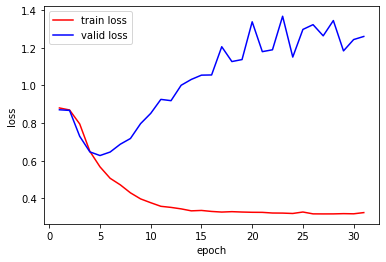

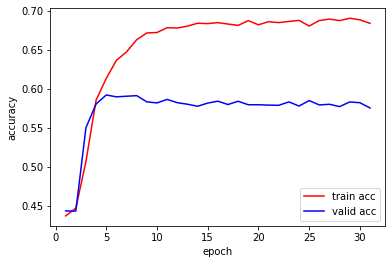

In [31]:
# dataset setting

TEXT = torchtext.legacy.data.Field(lower = True, batch_first = False, fix_length = 200)
LABEL = torchtext.legacy.data.Field(sequential= False)

train, test = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL) # IMDB dataset downlaod -> tokenize -> split with train/test data

TEXT.build_vocab(train,test, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=10)
LABEL.build_vocab(train,)

train_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size=32, shuffle=True)
train_iter.repeat = False
test_iter.repeat = False

n_vocab = len(TEXT.vocab)
n_hidden = 128

print("train dataset length: ", len(train_iter.dataset)) 

# model 
model = IMDBRnn(n_vocab, n_hidden, n_cat = 3, nl = 2, bs = 32)
model = model.cuda()

optimizer = optim.Adam(model.parameters(), lr = 1e-3)

def fit(epoch, model, dataloader, phase = 'training', volatile = False):
    if phase == 'training':
        model.train()
    if phase == "validation":
        model.eval()
        volatile = True # 이제는 필요 없다. torch.no_grad()로 대체되었다. 즉 gradient를 주지 않는다는 의미이다. 

    train_loss = 0
    train_acc = 0

    for batch_idx, batch in enumerate(tqdm_notebook(dataloader)):

        text, target = batch.text, batch.label

        if is_cuda:
            text, target = text.cuda(), target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        
        output = model(text)
        loss = F.nll_loss(output, target)

        train_loss += F.nll_loss(output, target, size_average=False).data
        preds = output.data.max(dim = 1, keepdim = True)[1] # output tensor type -> data로 호출 가능
        train_acc += preds.eq(target.data.view_as(preds)).cpu().sum()

        if phase == 'training':
            loss.backward()
            optimizer.step()
        
    train_loss = train_loss / len(dataloader.dataset)
    train_acc = train_acc.item() / len(dataloader.dataset)

    print("epoch: {} and loss: {} and acc : {}".format(epoch, train_loss, train_acc))

    return train_loss, train_acc

# training

train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

%time

for epoch in range(1, 32):
    epoch_loss, epoch_acc = fit(epoch, model, train_iter, phase = "training", volatile = False)
    val_epoch_loss, val_epoch_acc = fit(epoch, model, test_iter, phase = 'validation', volatile = True)

    train_losses.append(epoch_loss)
    valid_losses.append(val_epoch_loss)

    train_accuracy.append(epoch_acc)
    valid_accuracy.append(val_epoch_acc)

x_epoch = range(1, 32)


import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(x_epoch, train_losses, 'r', label = 'train loss')
plt.plot(x_epoch, valid_losses, 'b', label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(x_epoch, train_accuracy, 'r', label = 'train acc')
plt.plot(x_epoch, valid_accuracy, 'b', label = 'valid acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [19]:
train_iter

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


training loss is  0.85 and training accuracy is 11713/25000     46.85
validation loss is  0.75 and validation accuracy is 13190/25000     52.76
training loss is  0.68 and training accuracy is 14154/25000     56.62
validation loss is  0.69 and validation accuracy is 14082/25000     56.33
training loss is   0.6 and training accuracy is 14937/25000     59.75
validation loss is  0.67 and validation accuracy is 14348/25000     57.39
training loss is  0.55 and training accuracy is 15451/25000      61.8
validation loss is  0.69 and validation accuracy is 14395/25000     57.58
training loss is  0.51 and training accuracy is 15869/25000     63.48
validation loss is   0.7 and validation accuracy is 14561/25000     58.24
training loss is  0.47 and training accuracy is 15997/25000     63.99
validation loss is  0.74 and validation accuracy is 14646/25000     58.58
training loss is  0.44 and training accuracy is 16328/25000     65.31
validation loss is  0.81 and validation accuracy is 14362/25000   

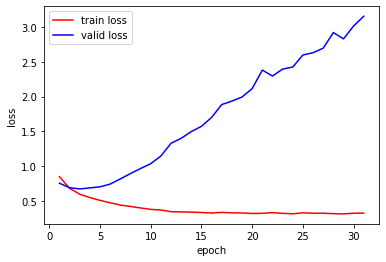

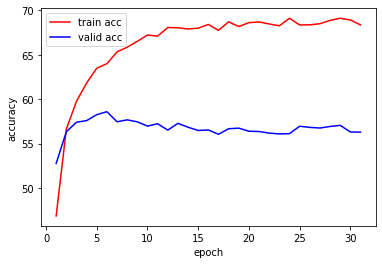

In [35]:
# using conv1d layer
TEXT = torchtext.legacy.data.Field(lower = True, batch_first = True, fix_length = 200)
LABEL = torchtext.legacy.data.Field(sequential= False)

train, test = torchtext.legacy.datasets.IMDB.splits(TEXT, LABEL) # IMDB dataset downlaod -> tokenize -> split with train/test data

TEXT.build_vocab(train,test, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=10)
LABEL.build_vocab(train,)

train_iter, test_iter = torchtext.legacy.data.BucketIterator.splits((train, test), batch_size=32, shuffle=True)
train_iter.repeat = False
test_iter.repeat = False

n_vocab = len(TEXT.vocab)
n_hidden = 100

class IMDBCnn(nn.Module):
    def __init__(self, vocab, hidden_size, n_cat, bs = 1, kernel_size = 3, maxlen = 200):
        super().__init__()
        self.hidden_size = hidden_size
        self.bs = bs
        self.embed = nn.Embedding(vocab, hidden_size) # vocab : 표현된 정수 인덱스의 개수, hidden_size는 임베딩 시 차원을 의미
        self.cnn = nn.Conv1d(maxlen, hidden_size, kernel_size) # (batch_size, maxlen, embed_size) => (batch_size, hidden_size, embed_size)로 전환, in_channel, out_channel은 tensorflow와 다르다.
        self.avg = nn.AdaptiveAvgPool1d(10) # hidden_size, hidden_size => hidden_size / 10, hidden_size 
        self.fc = nn.Linear(1000, n_cat)
        self.softmax = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):

        bs = inputs.size()[0]

        if bs != self.bs:
            self.bs = bs
        
        embed_out = self.embed(inputs)

        cnn_out = self.cnn(embed_out)
        cnn_avg = self.avg(cnn_out)
        cnn_avg = cnn_avg.view(self.bs, -1)

        fc = torch.nn.functional.dropout(self.fc(cnn_avg), p = 0.5)
        return self.softmax(fc)

model = IMDBCnn(n_vocab, n_hidden,n_cat=3,bs=32,kernel_size=2)
model = model.cuda()

optimizer = optim.Adam(model.parameters(),lr=1e-3)

def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , batch in enumerate(data_loader):
        text , target = batch.text , batch.label
        if is_cuda:
            text,target = text.cuda(),target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(text)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).data
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct.item()/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

# training

train_losses, train_accuracy = [], []
valid_losses, valid_accuracy = [], []

%time

for epoch in range(1, 32):
    epoch_loss, epoch_acc = fit(epoch, model, train_iter, phase = "training", volatile = False)
    val_epoch_loss, val_epoch_acc = fit(epoch, model, test_iter, phase = 'validation', volatile = True)

    train_losses.append(epoch_loss)
    valid_losses.append(val_epoch_loss)

    train_accuracy.append(epoch_acc)
    valid_accuracy.append(val_epoch_acc)


x_epoch = range(1, 32)

import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(x_epoch, train_losses, 'r', label = 'train loss')
plt.plot(x_epoch, valid_losses, 'b', label = 'valid loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(2)
plt.plot(x_epoch, train_accuracy, 'r', label = 'train acc')
plt.plot(x_epoch, valid_accuracy, 'b', label = 'valid acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# RNN module

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.output_size = output_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size) # W_xh와 W_hh를 concatenate한 상태
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), axis = 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))